## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install tensorflow-ranking

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from IPython.display import SVG
from keras.optimizers import adam_v2
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score
#import tensorflow_ranking as tfr
from keras.metrics import top_k_categorical_accuracy,MeanAbsoluteError
import numpy as np

In [ ]:
import tensorflow_ranking as tfr

In [ ]:
# Read data
interactions = pd.read_csv("/content/drive/MyDrive/CS646Project/rating_final.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Filter required columns
interactions = interactions[['userID','placeID','rating']]

In [ ]:
# Get data dimensions
len(interactions.userID.unique()), len(interactions.placeID.unique())

(138, 130)

In [ ]:
interactions.userID = interactions.userID.astype('category').cat.codes.values
interactions.placeID = interactions.placeID.astype('category').cat.codes.values

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
interactions.head()

,userID,placeID,rating
0,76,123,2
1,76,84,2
2,76,31,2
3,76,105,1
4,67,126,1


In [ ]:
user_id_dict = {}
k=0
for i in interactions['userID']:
  if i not in user_id_dict:
    user_id_dict[i] = k
    k+=1

place_id_dict = {}
k=0
for i in interactions['placeID']:
  if i not in place_id_dict:
    place_id_dict[i] = k
    k+=1

In [ ]:
# Map current user_id and recipe_id to continuous values, for easier matrix factorization
interactions['user_id_new']= interactions['userID'].map(user_id_dict)
interactions['place_id_new']= interactions['placeID'].map(place_id_dict)

<ipython-input-11-4bef667ad83c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions['user_id_new']= interactions['userID'].map(user_id_dict)


In [ ]:
# Filter the newly created id columns
df_new = interactions[['user_id_new','place_id_new','rating']]

In [ ]:
df = df_new.rename(columns={'user_id_new':'user_id','place_id_new':'place_id'})

In [ ]:
# Setup train and test data
X = df.iloc[:,:2]
Y = df.iloc[:,2]

In [ ]:
# Split data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

In [ ]:
n_users, n_places = len(df.user_id.unique()), len(df.place_id.unique())

In [ ]:
# No. of latent factors to retrieve

n_latent_factors = 20

In [ ]:
place_input = keras.layers.Input(shape=[1],name='Place')
#print("rec_input : ",rec_input)
#print("rec_input shape : ", rec_input.shape)
place_embedding = keras.layers.Embedding(n_places + 1, n_latent_factors, name='Places-Embedding')(place_input)
#print("rec_embedding : ",rec_embedding)
#print("rec_embedding shape : ",rec_embedding.shape)
place_vec = keras.layers.Flatten(name='FlattenRecipes')(place_embedding)
#print("rec_vec : ",rec_vec)
#print("rec_vec shape : ",rec_vec.shape)

user_input = keras.layers.Input(shape=[1],name='User')
print("user_input shape : ",user_input.shape)
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
print("user_embedding shape : ", user_embedding.shape)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
print("user_vec shape : ",user_vec.shape)
# prod = keras.layers.concatenate([user_vec, rec_vec], name='Concantenate')
# model = keras.Model([user_input, rec_input], prod)
# model.compile('adam', 'mean_squared_error')

user_input shape :  (None, 1)
user_embedding shape :  (None, 1, 20)
user_vec shape :  (None, 20)


In [ ]:
dotted = keras.layers.Dot(name="DotProduct",axes=1)([user_vec, place_vec])
print(dotted.shape)
model = keras.Model([user_input, place_input], dotted)
#model.compile('adam', 'mean_squared_error')

# Setup evaluation metrics
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=False),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=False)
]
optimizer = adam_v2.Adam(learning_rate = 0.0001)

model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=[keras.metrics.MeanAbsoluteError(),'top_k_categorical_accuracy',eval_metrics])

(None, 1)


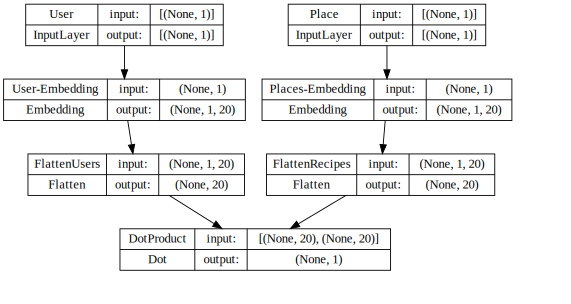

In [ ]:
# Visualize the baseline architecture
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Place (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 20)        2780        ['User[0][0]']                   
                                                                                                  
 Places-Embedding (Embedding)   (None, 1, 20)        2620        ['Place[0][0]']                  
                                                                                              

In [ ]:
x_test.head()

,user_id,place_id
397,57,88
726,92,0
986,119,34
918,114,37
117,24,52


In [ ]:
# Train the model
history = model.fit(x=[x_train.user_id, x_train.place_id], y=y_train, epochs=10, verbose=2, validation_data=([x_test['user_id'], x_test['place_id']], y_test))

Epoch 1/10
29/29 - 6s - loss: 2.0627 - mean_absolute_error: 1.2128 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 1.9273 - val_mean_absolute_error: 1.1499 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 6s/epoch - 223ms/step
Epoch 2/10
29/29 - 0s - loss: 1.9919 - mean_absolute_error: 1.1914 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 1.8593 - val_mean_absolute_error: 1.1306 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 373ms/epoch - 13ms/step
Epoch 3/10
29/29 - 0s - loss: 1.7322 - mean_absolute_error: 1.1097 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 1.5835 - val_mean_absolute_error: 1.0473 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 294ms/epoch - 10ms/step
Epoch 4/10
29/29 - 0s - loss: 1.1796 - mean_abso

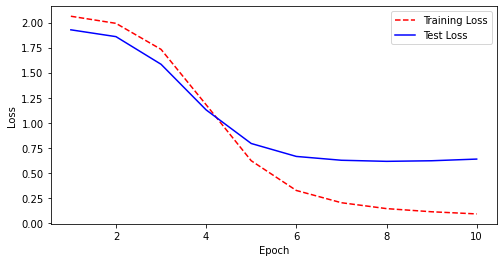

In [ ]:
# Plot the values
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()